In [2]:
%matplotlib inline
#%matplotlib notebook
#%matplotlib widget
import matplotlib 
import numpy as np
import pandas as pd
#import ipywidgets
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
 
# use LaTeX, choose nice some looking fonts and tweak some settings
matplotlib.rc('font', family='serif')
matplotlib.rc('font', size=16)
matplotlib.rc('legend', fontsize=16)
matplotlib.rc('legend', numpoints=1)
matplotlib.rc('legend', handlelength=1.5)
matplotlib.rc('legend', frameon=False)
matplotlib.rc('xtick.major', pad=7)
matplotlib.rc('xtick.minor', pad=7)
matplotlib.rc('text', usetex=True)
# matplotlib.rc('text.latex', 
#               preamble=[r'\usepackage[T1]{fontenc}',
#                         r'\usepackage{amsmath}',
#                         r'\usepackage{txfonts}',
#                         r'\usepackage{textcomp}'])

matplotlib.rc('figure', figsize=(12, 9))

In [3]:
sysmat_matlab_path=r"./hrmc_data/SystemMatrix_MATLAB.xlsx"
sysmat_mcnp_6_1_path=r"./hrmc_data/SystemMatrix_MCNP6_1.xlsx"


# read excel file : R=500, inner R=25
sysmat_matlab_excel = pd.read_excel(sysmat_matlab_path, None)
excel_keys = list(sysmat_matlab_excel.keys())
#print(excel_keys)
sysmat_matlab_excel=sysmat_matlab_excel[excel_keys[0]][0:360]
sysmat_matlab={}
#sysmat_matlab_excel.columns
sysmat_matlab["theta_10"]=sysmat_matlab_excel[["RotationAngle", "theta=10", "Unnamed: 2"]]
sysmat_matlab["theta_20"]=sysmat_matlab_excel[["RotationAngle", "theta=20", "Unnamed: 5"]]
sysmat_matlab["theta_30"]=sysmat_matlab_excel[["RotationAngle", "theta=30", "Unnamed: 8"]]
sysmat_matlab["theta_40"]=sysmat_matlab_excel[["RotationAngle", "theta=40", "Unnamed: 11"]]
sysmat_matlab["theta_50"]=sysmat_matlab_excel[["RotationAngle", "theta=50", "Unnamed: 14"]]
sysmat_matlab["theta_60"]=sysmat_matlab_excel[["RotationAngle", "theta=60", "Unnamed: 17"]]

for dd in sysmat_matlab:
    
    cc=sysmat_matlab[dd].columns
    sysmat_matlab[dd].columns = ["RotationAngle", "data", "Ndata"]
    #sysmat_matlab[dd].rename(columns={cc[2]:"Ndata"}, inplace=True) 
    
# read mcnp data
sysmat_mcnp_excel = pd.read_excel(sysmat_mcnp_6_1_path, None, header=1)
mcnp6_1_keys = list(sysmat_mcnp_excel.keys())
print(mcnp6_1_keys)
sysmat_mcnp_excel=sysmat_mcnp_excel[mcnp6_1_keys[0]]
sysmat_mcnp={}
sysmat_mcnp["theta_10"]=sysmat_mcnp_excel.iloc[:360, 0:3]
sysmat_mcnp["theta_20"]=sysmat_mcnp_excel.iloc[:360, 3:6]
sysmat_mcnp["theta_30"]=sysmat_mcnp_excel.iloc[:360, 6:9]
sysmat_mcnp["theta_40"]=sysmat_mcnp_excel.iloc[:360, 9:12]
sysmat_mcnp["theta_50"]=sysmat_mcnp_excel.iloc[:360, 12:15]
sysmat_mcnp["theta_60"]=sysmat_mcnp_excel.iloc[:360, 15:18]

for dd in sysmat_mcnp :
    sysmat_mcnp[dd].columns = ["RotationAngle", "data", "Ndata"]
    

    
def shift_matlab_data(matlab_data, shiftangle=0.0, sort=False):
    rangle = np.fmod(matlab_data["RotationAngle"]+shiftangle, 360.0)
    data = matlab_data["data"]
    Ndata = data/data.max()
    result = pd.DataFrame({"RotationAngle" : rangle, "data": data, "Ndata": Ndata})
    if sort:
        result = result.sort_values(by=["RotationAngle",])
    return result
    
def make_system_matrix_by_matlab():
    ncolumn = 0 
    for kk in sysmat_matlab :
        ncolumn += sysmat_matlab[kk].shape[0]
    print(ncolumn)
    nrow = 360
    cnames=("theta_10", "theta_20", "theta_30","theta_40", "theta_50","theta_60")
    result = np.zeros((nrow, ncolumn))
    for indrow in range(nrow):
        inc = indrow
        for ind, cname in enumerate(cnames):
            tdata = (shift_matlab_data(sysmat_matlab[cname], inc, True))["data"]
            result[indrow, (tdata.shape[0]*ind): (tdata.shape[0]*(ind+1))]=tdata
    result = result/result.max()
    return result
    
    
def mlem(data, const, nitter):
    pij=make_system_matrix_by_matlab()
    aj=np.ones(pij.shape[1])    
    bi=np.ones(pij.shape[0])*const
    yi = data["data"]*3000
    print(yi.max())
    for i in range(nitter):
        aa = aj.copy()
        ci = yi/(np.dot(pij, aa)+bi)
        aj=(aa/(pij.sum(axis=0)))*np.dot(ci, pij)
        
    return aj

['Ba-133 (356 keV)']


<AxesSubplot:xlabel='RotationAngle'>

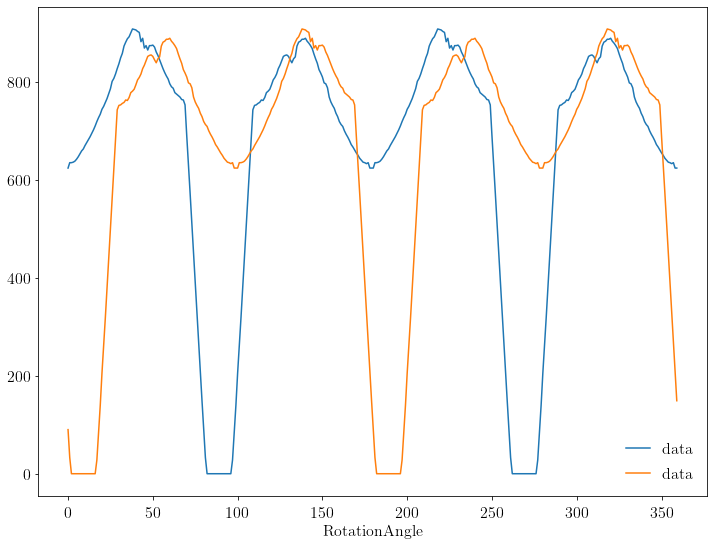

In [4]:
data1=sysmat_matlab["theta_10"]
data2=shift_matlab_data(shift_matlab_data(data1, 30.0, True), 70., True)
fig, ax = plt.subplots()
data1.plot(x=0, y=1, ax=ax)
data2.plot(x=0, y=1, ax=ax)

2160
2160
9.277800000000001


(3.0718290181844127e-41, 2.057619682585492e-65)

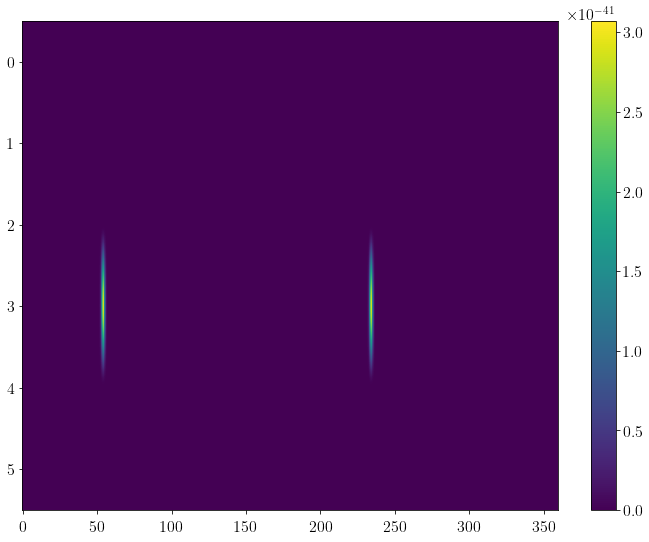

In [5]:
dd=make_system_matrix_by_matlab()
rr=mlem(shift_matlab_data(sysmat_mcnp["theta_40"], 55.0, True), 10, 500)
plt.imshow(rr.reshape(6, 360), aspect='auto')
plt.colorbar()
rr.max(), rr.min()

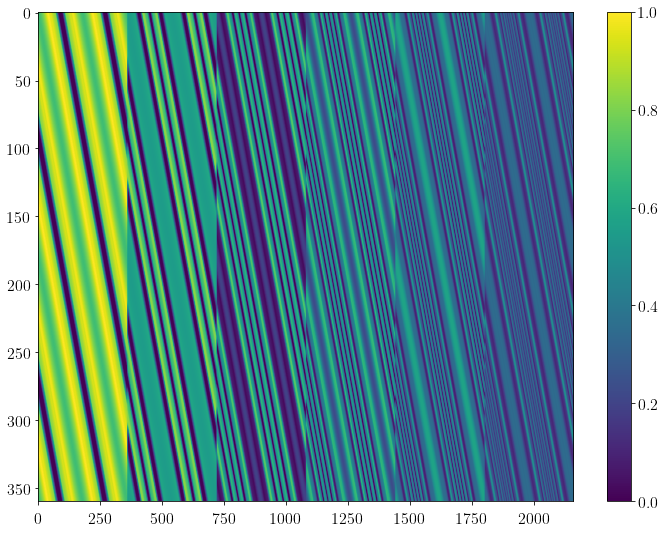

In [362]:
plt.imshow(dd, aspect='auto')
plt.colorbar()

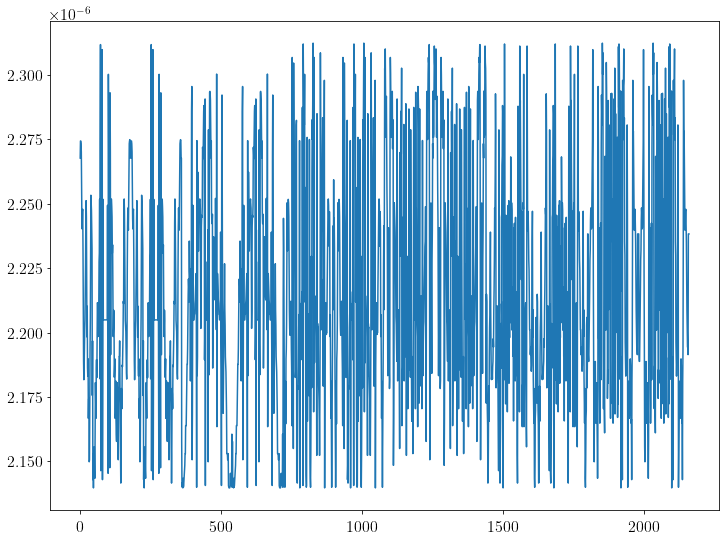

In [191]:
sysmat_mcnp["theta_50"].shape

(360, 3)

<AxesSubplot:xlabel='RotationAngle'>

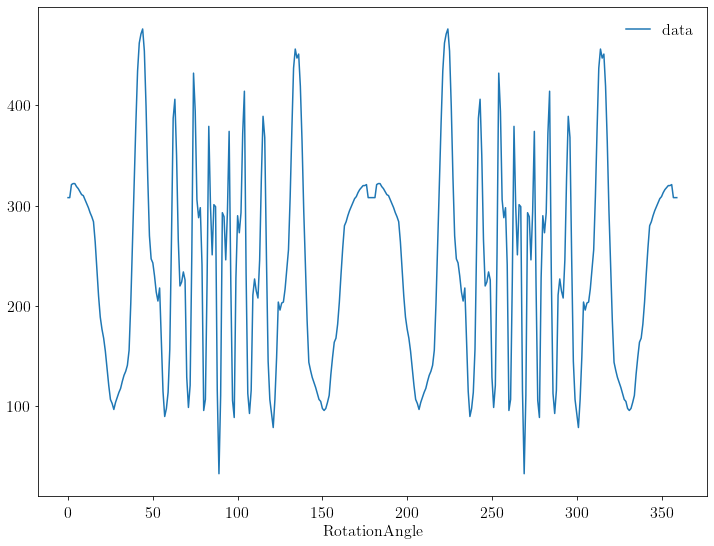

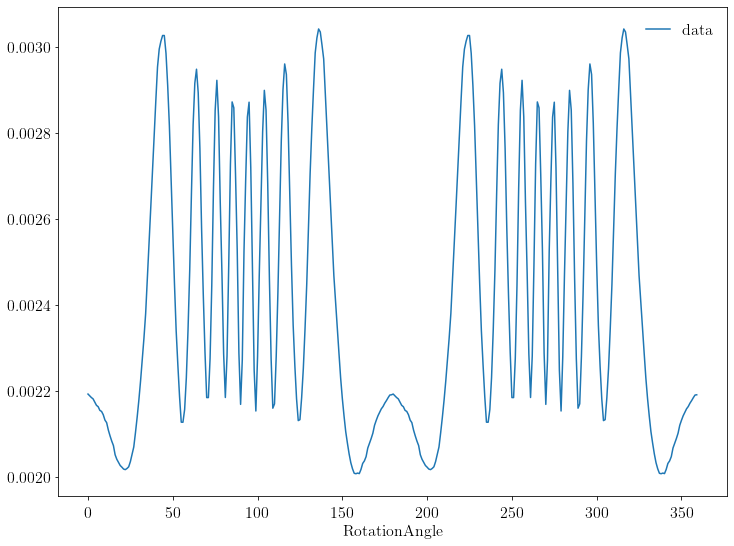

In [161]:
sysmat_matlab["theta_60"].plot(x=0, y=1)
sysmat_mcnp["theta_60"].plot(x=0, y=1)

In [166]:
print(np.fmod(750, 360.0))
print(100-35.3*2)

30.0
29.400000000000006


In [94]:
sysmat_matlab["theta_10"]["Ndata"]

0      0.687225
1      0.699339
2      0.699339
3      0.700441
4      0.702643
         ...   
355    0.699339
356    0.697137
357    0.699339
358    0.687225
359    0.687225
Name: Ndata, Length: 360, dtype: float64

In [95]:
sysmat_matlab_excel

,RotationAngle,theta=10,Unnamed: 2,Unnamed: 3,theta=20,Unnamed: 5,Unnamed: 6,theta=30,Unnamed: 8,Unnamed: 9,theta=40,Unnamed: 11,Unnamed: 12,theta=50,Unnamed: 14,Unnamed: 15,theta=60,Unnamed: 17,Unnamed: 18,Unnamed: 19
0,0.0,624,0.687225,NaN,495,0.655629,NaN,174,0.251809,NaN,206,0.328025,NaN,521,0.973832,NaN,308,0.647059,NaN,"target : 검출기 중심 (0,0,5)"
1,1.0,635,0.699339,NaN,503,0.666225,NaN,185,0.267728,NaN,223,0.355096,NaN,535,1.000000,NaN,308,0.647059,NaN,"선원위치 : (500, tht, 0)"
2,2.0,635,0.699339,NaN,504,0.667550,NaN,181,0.261939,NaN,217,0.345541,NaN,534,0.998131,NaN,321,0.674370,NaN,Blue line : MCNP6 / Red line : Matlab
3,3.0,636,0.700441,NaN,502,0.664901,NaN,170,0.246020,NaN,226,0.359873,NaN,524,0.979439,NaN,322,0.676471,NaN,slat 7deg / inner radius 25mm
4,4.0,638,0.702643,NaN,505,0.668874,NaN,163,0.235890,NaN,233,0.371019,NaN,520,0.971963,NaN,322,0.676471,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
355,355.0,635,0.699339,NaN,502,0.664901,NaN,169,0.244573,NaN,223,0.355096,NaN,520,0.971963,NaN,320,0.672269,NaN,NaN
356,356.0,633,0.697137,NaN,502,0.664901,NaN,179,0.259045,NaN,216,0.343949,NaN,531,0.992523,NaN,321,0.674370,NaN,NaN
357,357.0,635,0.699339,NaN,502,0.664901,NaN,184,0.266281,NaN,220,0.350318,NaN,532,0.994393,NaN,308,0.647059,NaN,NaN
358,358.0,624,0.687225,NaN,494,0.654305,NaN,173,0.250362,NaN,206,0.328025,NaN,523,0.977570,NaN,308,0.647059,NaN,NaN


In [322]:
aa=np.array([1, 2, 3,])
bb=aa.copy()

In [323]:
bb[0]=5

In [324]:
bb

array([5, 2, 3])

In [325]:
aa

array([1, 2, 3])